# Sea turtles data extraction - from Access file


### Background
Israel Nature and Parks Authority (INPA) is conducting an ecological program for Sea turtles conservation.
Along the summer months, INPA's rangers and ecologysts are searching for sea turtles nests along the beach. Once a nest is found- in many cases it's being transferred to a safe farm and taken care until the juvenile turtles are hatching.


### The data
Data of this program is being recorded since 1985- at the begining of the project . In the first years the data was collected using papers, and later on the data was computerized. Nowadays, an app is being used in order to enter the project data.

The data that I have been asked to work on is the historical data- this data is saved on an Acess file, and haven't been in use since 2015 - when the project started being documented using the new app.

In order to extract the data I wrote this notebook using python.

The data itself is confidential - therefore was not presented in this project.

### Destination dataframes:
The current data is formed in 4 categories - for which this DB should be exported to
1. nests and nest removals 
2. nest relocations
3. nest checks
4. nest opening


In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import sqlalchemy as sa


In [3]:
## import data into pandas data-frames

driver = "{Microsoft Access Driver (*.mdb, *.accdb)}"
db_path = "C:/Users/michalsh/Downloads/TurtlesDB_be.mdb"
engine_string = 'DRIVER=%s;DBQ=%s;' % (driver,db_path)
engine_url = sa.engine.URL.create(
    "access+pyodbc",
    query={"odbc_connect": engine_string})

engine = sa.create_engine(engine_url)

table_names=['AcHatch','AcCrawl', 'Activities', 'Clutches', 'ClutchToNest','Contact',
      'ContactPosition', 'Crawl', 'CrawlContact', 'CrawlPredator', 'Hatcheries',
      'Immerging', 'Location', 'Nest', 'Organization', 'Specie', 'TurtleEvent', 'Regions']

for table_name in table_names:
    query ="SELECT * FROM %s" %(table_name)
    df = pd.read_sql(query, engine)
    globals()['df_%s' % table_name] = df


In [4]:
### generating df_Crawl_oiginal , where all original rows before duplication removal will be present
df_Crawl_oiginal = df_Crawl 
# df_Crawl_oiginal.to_excel('Crawl_original.xlsx')


### Contacts table
The contacts table was cleaned- removed unnecessary columns, removed unwanted figures and NAs, and generated a full name column:

In [5]:
### orginizing and cleaning Contacts dataframe

### --- Generate FullName column without null values.

df_Contact['FullName']= df_Contact['ContactFname'].fillna('') + ' ' + df_Contact['ContactLname'].fillna('')
df_Contacts_clean = df_Contact[['ContactId', 'ContactIDNum', 'ContactPosition', 'BeachSurveyor',
       'NestRelocator', 'NestExcavator', 'ContactGender', 'ContactE-mail',
       'ContactNotes','FullName']]


### test- check for nan FullNames:
if df_Contacts_clean['FullName'].isnull().values.any():
    print ('there are null values!')


### --- Adding position and organization to contacts
df_ContactPosition_Organization = pd.merge(df_ContactPosition, df_Organization, left_on='Organization', right_on='OrganizationID', how='left')
df_Contacts_Position_Organization = pd.merge(df_Contacts_clean, df_ContactPosition_Organization, left_on='ContactPosition', right_on='PositionID', how='left')


### re assigning to original variable:
df_Contact = df_Contacts_Position_Organization

### Location table
merged relevant data into one dataframe to be used for location information

In [6]:
### location df
df_Regions_clean = df_Regions.drop(['RegionSite', 'RegionNorth', 'RegionSouth', 'RegionEast', 'RegionWest'], axis=1)
df_Location_Regions = pd.merge(df_Location, df_Regions_clean, left_on='Region', right_on='RegionId', how='left')
# print(df_Location.shape[0] == df_Location_Regions.shape[0])

### re assigning to original variable:
df_Location = df_Location_Regions

### Crawls table:
added species, location and contacts to this table, removed irrelevant data

In [7]:
### Crawls df
# 1 --- adding species, location to crawls ---
df_Crawl_clean = df_Crawl.drop(['RegionalCrawlID'], axis=1)
df_Specie_clean = df_Specie.drop(['SpeciePic'], axis=1)
df_Crawl_Specie = pd.merge(df_Crawl_clean, df_Specie_clean, left_on='SpecieID', right_on='SpecieId',how='left')
df_Crawl_Specie_Location = pd.merge(df_Crawl_Specie, df_Location, left_on= 'Location', right_on='LocationID', how='left')

In [8]:
# 2 --- adding contacts info ---
def GetContact(contact_id):
    contact = df_Contact.loc[df_Contact['ContactId'] == contact_id]
    # contact_name = contact['FullName'].item()
    return contact

df_Crawl_Specie_Location_Contacts = df_Crawl_Specie_Location

crawl_ids_counter = Counter(df_CrawlContact.CrawlID)
for crawl_id in crawl_ids_counter.keys():
    more_contacts_str =''
    contacts_ids=df_CrawlContact.loc[df_CrawlContact.CrawlID == crawl_id]
    contact_list = []

    for contact_id in contacts_ids['ContactID']:
        contact = GetContact(contact_id)
#     for crawlcontact_id in contacts_ids['ContactID']:
#         contact = df_Contact.loc[df_Contact['ContactId'] == crawlcontact_id]
        contact_name = contact['FullName'].item()
        contact_list.append(contact_name)

    main_contact_name = contact_list[0]
    if len(contact_list)>0:
        more_contacts_str = ', '.join(contact_list[1:])

    updating_index = np.where(df_Crawl_Specie_Location_Contacts['CrawlID']==crawl_id)[0][0]
    df_Crawl_Specie_Location_Contacts.at[updating_index,'other_observers_names'] = more_contacts_str
    df_Crawl_Specie_Location_Contacts.at[updating_index,'main_observer_name'] = main_contact_name
    df_Crawl_Specie_Location_Contacts.at[updating_index, 'CrawlID']

    contacts_ids_list = []
    for i in contacts_ids['ContactID']:
        contacts_ids_list.append(str(i))
    contacts_ids_str = ', '.join(contacts_ids_list)
    df_Crawl_Specie_Location_Contacts.at[updating_index, 'contacts_ids'] = contacts_ids_str


I added contacts to clutches and to nests tables as well


In [9]:
## adding contacts to clutches and to nests as well

clutches_ids_counter = Counter(df_Clutches.ClutchID)

for clutch_id in clutches_ids_counter.keys():
    clutch = df_Clutches.loc[df_Clutches.ClutchID == clutch_id]
    collector_contact_id=clutch['CollectorID']
    relocator_contact_id=clutch['RelocatorID']
    updating_index = np.where(df_Clutches['ClutchID']==clutch_id)[0][0]

    if not collector_contact_id.isnull().any():
        collector_contact_id = int(collector_contact_id.values)
#         print('collector_contact_id: ',collector_contact_id)
        try:
            collector_contact_name = GetContact(collector_contact_id)['FullName'].item()
#             print(collector_contact_name)
            df_Clutches.at[updating_index,'CollectorContact'] = collector_contact_name

        except:
            print('collector does not exist! collector_contact_id: ',collector_contact_id)
            continue

    if not relocator_contact_id.isnull().any():
        relocator_contact_id = int(relocator_contact_id.values)
#         print('relocator_contact_id: ',relocator_contact_id)
        relocator_contact_name = GetContact(relocator_contact_id)['FullName'].item()
        df_Clutches.at[updating_index,'RelocatorContact'] = relocator_contact_name


collector does not exist! collector_contact_id:  577


In [10]:
df_Nest.columns

Index(['NestID', 'HatcheryNestNo', 'HatcheryID', 'HatchingDate', 'OpeningDate',
       'OpeningHour', 'OpenerID', 'OpeningNotes', 'EmptyShells', 'LiveInNest',
       'DeadInNest', 'DeadInEggs', 'UndevelopedEggs', 'NestOwner',
       'NestOwnerCode', 'NestAddingDate'],
      dtype='object')

### Nests table
I also added to nests table:
- Opener name
- Owner name
- Hatchery name and coordinates

In [11]:
## OpenerID
df_Contact_relevant = df_Contact[['ContactId','FullName']].copy()
df_Contact_relevant.columns=['NestOpenerID',"NestOpenerName"]
df_Nest2 = pd.merge(df_Nest, df_Contact_relevant, left_on='OpenerID', right_on='NestOpenerID', how='left').drop(columns = ['NestOpenerID'])
df_Nest2
df_Nest = df_Nest2


## OwnerID
df_Contact_relevant.columns=['NestOwnerID',"NestOwnerName"]
df_Nest2 = pd.merge(df_Nest, df_Contact_relevant, left_on='NestOwnerCode', right_on='NestOwnerID', how='left').drop(columns = ['NestOwnerID'])
df_Nest2
df_Nest = df_Nest2

In [12]:
### adding hatchery name:
# HatcheryID
df_Hatcheries_relevant = df_Hatcheries[['HatcheryID','HatcheryName','HatcheryNorth','HatcherySouth']]
df_Nest2 = pd.merge(df_Nest, df_Hatcheries_relevant, left_on='HatcheryID', right_on='HatcheryID', how='left')
df_Nest2
df_Nest = df_Nest2


In [13]:
df_Nest

,NestID,HatcheryNestNo,HatcheryID,HatchingDate,OpeningDate,OpeningHour,OpenerID,OpeningNotes,EmptyShells,LiveInNest,...,DeadInEggs,UndevelopedEggs,NestOwner,NestOwnerCode,NestAddingDate,NestOpenerName,NestOwnerName,HatcheryName,HatcheryNorth,HatcherySouth
0,1,None,10.0,1989-08-11,NaT,NaT,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,-InSitu-,NaN,NaN
1,2,None,10.0,1989-09-20,NaT,NaT,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,-InSitu-,NaN,NaN
2,3,None,10.0,NaT,NaT,NaT,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,-InSitu-,NaN,NaN
3,4,None,10.0,NaT,NaT,NaT,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,-InSitu-,NaN,NaN
4,5,None,10.0,NaT,NaT,NaT,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,-InSitu-,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,4081,18,4.0,NaT,2015-09-04,1899-12-30 18:30:00,NaN,None,52.0,1.0,...,5.0,8.0,0.0,NaN,2016-05-15,NaN,NaN,Gdor,708300.0,668000.0
2262,4082,19,4.0,NaT,2015-08-30,1899-12-30 19:00:00,NaN,דווח על 65 הגחות עד לפתיחה,68.0,0.0,...,4.0,5.0,0.0,NaN,2016-05-15,NaN,NaN,Gdor,708300.0,668000.0
2263,4087,20,4.0,NaT,2015-08-29,1899-12-30 19:00:00,NaN,None,62.0,2.0,...,0.0,7.0,0.0,NaN,2016-05-15,NaN,NaN,Gdor,708300.0,668000.0
2264,4088,23,4.0,NaT,2015-09-11,1899-12-30 18:00:00,NaN,None,58.0,0.0,...,2.0,5.0,0.0,NaN,2016-05-15,NaN,NaN,Gdor,708300.0,668000.0


In [14]:
df_Nest.HatcheryNestNo.unique()


array([None, '1', '2', '6', '7', '8', '11', '13', '14', '15', '17', '20',
       '23', '25', '26', '27', '28', '29', '31', '32', '37', '38', '39',
       '40', '42', '43', '45', '48', '53', '60', '9', '3', '19', '24',
       '30', '12', '16', '4', '22', '33', '36', '5', '61', '62', '65',
       '66', '67', '68', '74', '78', '79', '80', '51', '47', '41', '35',
       '21', '18', '10', '34', '44', '46', '50', '52', '57', '59', '64',
       '54', '56', '63', '20a', '49', '69', '70', '5a', '7a', '13a', '58',
       '71', '72', '86', '55', '84', '85', '87', '88', '12a', '18a', '6a',
       '73', '20b', '12b', '2a', '9a', '4a', '21a', '36a', '15a', '1a',
       '3a', '15ב', '1א', '21ב', '21א', '10a', '1ב', '5א', '5ב', '16א',
       '16ב', '7א', '7ב', '3א', '3ב', '0'], dtype=object)

I merged nests data with immerging data - as they're in the same destination file.

In [15]:
df_Nest_relevant = df_Nest[['NestID','HatcheryID', 'HatcheryName', 'HatcheryNorth', 'HatcherySouth']]
df_Immerging2 = pd.merge(df_Immerging, df_Nest_relevant, left_on='NestID', right_on='NestID', how='left')
df_Immerging = df_Immerging2
df_Immerging

,ImmergeID,NestID,ImmergeDay,ImmergeTimeS,ImmergeTimeE,NoOfTurtles,ImmregeRemarks,HatcheryID,HatcheryName,HatcheryNorth,HatcherySouth
0,632,2009,2007-08-30,1899-12-30 00:00:00,NaT,14.0,0.0,4.0,Gdor,708300.0,668000.0
1,633,2009,2007-08-30,1899-12-30 03:00:00,NaT,2.0,0.0,4.0,Gdor,708300.0,668000.0
2,634,2009,2007-08-30,1899-12-30 04:30:00,NaT,2.0,0.0,4.0,Gdor,708300.0,668000.0
3,635,2009,2007-08-29,1899-12-30 23:30:00,NaT,1.0,0.0,4.0,Gdor,708300.0,668000.0
4,636,2009,2007-08-29,1899-12-30 02:20:00,NaT,2.0,0.0,4.0,Gdor,708300.0,668000.0
...,...,...,...,...,...,...,...,...,...,...,...
4833,6391,4004,2014-08-28,NaT,1899-12-30 08:30:00,1.0,0.0,11.0,Difle,NaN,NaN
4834,6392,4005,2014-08-23,NaT,1899-12-30 21:50:00,4.0,0.0,11.0,Difle,NaN,NaN
4835,6393,4007,2014-07-30,NaT,1899-12-30 04:00:00,50.0,0.0,1.0,Betzet,778000.0,749000.0
4836,6394,4007,2014-07-30,NaT,1899-12-30 14:00:00,1.0,0.0,1.0,Betzet,778000.0,749000.0


### Predators
I added predators information to crawl table

In [16]:
# 3 --- adding predators ---
df_Crawl_Specie_Location_Contacts_Predators = df_Crawl_Specie_Location_Contacts
crawl_predators_ids_counter = Counter(df_CrawlPredator.CrawlID)

for crawl_id in crawl_predators_ids_counter.keys():
    if not crawl_id >0:
        print('is a null values', crawl_id)
    else:
        crawl_predators = df_CrawlPredator.loc[df_CrawlPredator.CrawlID == crawl_id]
        crawl_predators_list = []

        for crawl_predator in crawl_predators['PredatorTrack']:
            if crawl_predator == None:
                print('--------------------crawlpredator == None---------------------------')
            else:
                updating_index = np.where(df_Crawl_Specie_Location_Contacts_Predators['CrawlID']==crawl_id)[0][0]
                df_Crawl_Specie_Location_Contacts_Predators.at[updating_index,'predation'] = "yes"
                df_Crawl_Specie_Location_Contacts_Predators.at[updating_index,crawl_predator] = 1



is a null values nan
is a null values nan
is a null values nan
--------------------crawlpredator == None---------------------------


In [17]:
# 4 --- reassigning to original df variable ---

df_Crawl = df_Crawl_Specie_Location_Contacts_Predators
df_Crawl.loc[df_Crawl.predation=="yes"]

,CrawlID,SerialNo,Nest,ListingDate,CrawlDate,OnlyYear,Location,North,East,DescriptionOfCrawl,...,contacts_ids,predation,Fox,Dog,Man,unknown,crab,Crow,Cat,Crab
54,56,22.0,True,NaT,1994-06-28,False,59.0,717500.0,191300.0,None,...,463,yes,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
113,126,16.0,True,NaT,1991-07-28,False,4.0,775600.0,210200.0,None,...,460,yes,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,127,24.0,True,NaT,1991-06-12,False,49.0,730900.0,193700.0,מע' ללולי קיבוץ נוה ים,...,463,yes,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,129,29.0,True,NaT,1991-06-26,False,50.0,729400.0,193600.0,200 מ' דר' לתל נאמי,...,463,yes,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,163,1.0,True,NaT,1990-06-22,False,126.0,626700.0,161400.0,None,...,541,yes,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,162477,NaN,True,2016-05-15,2015-06-16,False,72.0,NaN,NaN,None,...,"849, 2149",yes,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4187,162478,NaN,True,2016-05-15,2015-06-19,False,80.0,NaN,NaN,חוף הדתיים,...,1099,yes,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4190,162481,NaN,True,2016-05-15,2015-06-25,False,84.0,NaN,NaN,פולג-חוף השרון,...,839,yes,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4193,162484,NaN,True,2016-05-15,2015-07-02,False,77.0,NaN,NaN,None,...,1099,yes,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## Inspecting data for issues

#### Checking for duplications:
When a turtle is going on shore to lay eggs - that's a **crawl** .

Somethimes she's going on shore without laying eggs. 

If there are eggs - then that is a **clutch** (or rarely 2 clutches).

Then the bioligists will decide - if to keep the clutch or to take it to a hatchery....

if one crawl is connected to few clutches - we need to inspect it more because it's not normal.


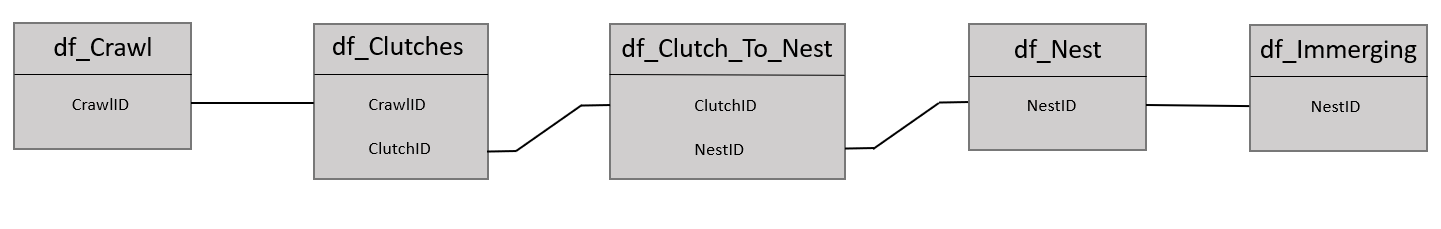


In [18]:
# are there *Clutches* connected to same *Crawls*?:
print(df_Clutches.duplicated(subset='CrawlID').sum()) ###duplications of crawl ids in clutches df

40


It means that few CrawlIDs appear few times -meaning that *few clutches have the same Crawl ID*.

or anther way to put is- few cases where one Crawl is connected to few Clutches. 

#### visually inspecting duplicates in clutches and nests

I'll investigate these clutches - are they similar or identical? or are there any differences?
Is there any important data in these clutches that I should keep?

In [19]:
## all rows with same CrawlID:
df_Clutches.loc[df_Clutches.CrawlID.duplicated(keep=False)].sort_values('CrawlID').drop(['CollectingDate','RelocationDate' ],axis=1)  ##dropping sensitive data



,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectionHour,CollectorID,RelocationHour,RelocatorID,WasRelocated,CollectorContact,RelocatorContact
1312,1807,5072,94.0,36.0,60.0,22.0,26.0,0.0,Not preyed,0.0,1899-12-30 08:30:00,331.0,1899-12-30 09:00:00,331.0,True,Kobi Sofer,Kobi Sofer
1400,1975,5072,94.0,36.0,60.0,22.0,26.0,0.0,Not preyed,0.0,1899-12-30 08:30:00,NaN,1899-12-30 09:00:00,NaN,True,NaN,NaN
1343,1838,5103,116.0,20.0,52.0,25.0,12.0,5.0,Not preyed,0.0,1899-12-30 15:00:00,NaN,1899-12-30 17:00:00,NaN,True,NaN,NaN
1401,2062,5103,116.0,20.0,52.0,25.0,12.0,5.0,Not preyed,0.0,1899-12-30 15:00:00,NaN,1899-12-30 17:00:00,NaN,True,NaN,NaN
1963,3231,161696,120.0,31.0,51.0,23.0,0.0,0.0,Not prayed,0.0,1899-12-30 07:00:00,211.0,1899-12-30 09:00:00,211.0,True,Uri Nave,Uri Nave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2978,161720,84.0,36.0,53.0,22.0,33.0,0.0,Not prayed,0.0,1899-12-30 07:40:00,487.0,1899-12-30 08:30:00,NaN,True,Yatir Shamir,NaN
1836,3006,161750,78.0,40.0,56.0,24.0,16.0,0.0,Not prayed,0.0,1899-12-30 07:30:00,250.0,1899-12-30 10:00:00,250.0,True,Galia Pasternak,Galia Pasternak
1835,3005,161750,78.0,40.0,56.0,24.0,16.0,0.0,Not prayed,0.0,1899-12-30 07:30:00,250.0,1899-12-30 10:00:00,250.0,True,Galia Pasternak,Galia Pasternak
1962,3195,162103,91.0,35.0,50.0,20.0,15.0,0.0,Not prayed,0.0,1899-12-30 08:30:00,237.0,1899-12-30 09:30:00,237.0,True,Ben Rozenberg,Ben Rozenberg


clutches seems indeed identical (except for less important of data of RelocatorID in clutchid=1807).

I'll check if theses clutches are leading to the same nests - if they do - then I can disgard them.

In [20]:
duplicated_clutches_crawlids=np.unique(df_Clutches.loc[df_Clutches.CrawlID.duplicated()]['CrawlID'].values)

for crawlid in duplicated_clutches_crawlids:
    crawl= df_Crawl.loc[df_Crawl.CrawlID==crawlid]
    clutches = df_Clutches.loc[df_Clutches.CrawlID==crawlid]
    clutchids= clutches['ClutchID'].values
    print('crawlid : ', crawl['CrawlID'].values,)

    for clutchid in clutchids:
        nestids=df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]['NestID'].values
        print('clutch id: ', clutchid,'\t' 'nestids: ',nestids)
    print('\n')    



crawlid :  [5072]
clutch id:  1807 	nestids:  [2598]
clutch id:  1975 	nestids:  []


crawlid :  [5103]
clutch id:  1838 	nestids:  [2628 2630]
clutch id:  2062 	nestids:  []


crawlid :  [161696]
clutch id:  2961 	nestids:  [3498 3615 3774]
clutch id:  3051 	nestids:  [3498 3615 3774]
clutch id:  3231 	nestids:  [3498 3774 3615]


crawlid :  [161698]
clutch id:  2962 	nestids:  [3500 3617 3776]
clutch id:  3052 	nestids:  [3500 3617 3776]
clutch id:  3232 	nestids:  [3500 3776 3617]


crawlid :  [161700]
clutch id:  2963 	nestids:  [3518 3673 3832]
clutch id:  3053 	nestids:  [3518 3673 3832]
clutch id:  3233 	nestids:  [3518 3673 3832]


crawlid :  [161701]
clutch id:  2964 	nestids:  [3502 3619 3778]
clutch id:  3054 	nestids:  [3502 3619 3778]
clutch id:  3234 	nestids:  [3502 3778 3619]


crawlid :  [161702]
clutch id:  2965 	nestids:  [3519 3674 3833]
clutch id:  3055 	nestids:  [3519 3674 3833]
clutch id:  3235 	nestids:  [3519 3674 3833]


crawlid :  [161703]
clutch id:  2966 	

In [21]:
### checking a specific case

crawlid = 161717
clutchids = [2975, 3065 ,3245]
nestids =  [3517, 3634, 3793]

crawl = df_Crawl.loc[df_Crawl.CrawlID==161717]
clutches = df_Clutches.loc[df_Clutches.ClutchID.isin(clutchids)]
nests = df_Nest.loc[df_Nest.NestID.isin(nestids)]
clutchestonests = df_ClutchToNest.loc[df_ClutchToNest.NestID.isin(nestids)]

print(crawl)
print(clutches)
print(nests)
print(clutchestonests.sort_values('NestID'))

# clutchestonests.to_excel('clutchestonests.xlsx')

      CrawlID  SerialNo  Nest ListingDate  CrawlDate  OnlyYear  Location   
3707   161717       NaN  True  2012-06-12 2012-06-12     False     131.0  \

      North  East DescriptionOfCrawl  ...  contacts_ids  predation  Fox  Dog   
3707    NaN   NaN               None  ...           331        NaN  NaN  NaN  \

      Man unknown  crab Crow  Cat  Crab  
3707  NaN     NaN   NaN  NaN  NaN   NaN  

[1 rows x 47 columns]
      ClutchID  CrawlID  EggsNo  DeptTopEgg  DepthBottomEgg  NestDiameter   
1805      2975   161717    82.0        32.0            58.0          20.0  \
1894      3065   161717    82.0        32.0            58.0          20.0   
1977      3245   161717    82.0        32.0            58.0          20.0   

      NestDistance  BrokenOnRelocation   Predation  PreyedEggs CollectingDate   
1805          20.0                 0.0  Not prayed         0.0     2012-06-12  \
1894          20.0                 0.0  Not prayed         0.0     2012-06-12   
1977          20.0         

In [22]:

## 1 - removing clutches duplications- bysame crawl id

duplicated_clutches = []
duplicated_c=clutches.duplicated(subset='CrawlID',keep='first') 

if duplicated_c.any() ==True:
    duplicated_clutches = duplicated_clutches+list(clutches[duplicated_c]['ClutchID'].values)



### nests

nests_without_duplicates=nests.drop_duplicates(subset=['HatcheryNestNo', 'HatcheryID', 'HatchingDate','OpeningDate','OpeningHour','EmptyShells',
                         'LiveInNest' , 'DeadInNest','DeadInEggs','UndevelopedEggs', 'NestAddingDate']
                                               ,keep='first') 


duplicated_nests = []
duplicated= nests.duplicated(subset=['HatcheryNestNo', 'HatcheryID', 'HatchingDate','OpeningDate','OpeningHour','EmptyShells',
                 'LiveInNest' , 'DeadInNest','DeadInEggs','UndevelopedEggs', 'NestAddingDate'],keep='first') 
        
if duplicated.any() ==True:
    duplicated_nests = duplicated_nests+list(nests[duplicated]['NestID'].values)




In [23]:
# clutches_without_duplicates
duplicated_clutches

[3065, 3245]

In [24]:
# nests_without_duplicates
# nests.duplicated(subset=['HatcheryNestNo', 'HatcheryID', 'HatchingDate','OpeningDate','OpeningHour','EmptyShells',
#                  'LiveInNest' , 'DeadInNest','DeadInEggs','UndevelopedEggs', 'NestAddingDate'],keep='first') 

list(nests[duplicated]['NestID'].values)

[3634, 3793]

In [25]:
df_Clutches.loc[df_Clutches.ClutchID.isin([3264,2975])]


,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,RelocationDate,RelocationHour,RelocatorID,WasRelocated,CollectorContact,RelocatorContact
1805,2975,161717,82.0,32.0,58.0,20.0,20.0,0.0,Not prayed,0.0,2012-06-12,1899-12-30 07:00:00,331.0,2012-06-12,1899-12-30 07:30:00,331.0,True,Kobi Sofer,Kobi Sofer
1996,3264,162189,82.0,32.0,58.0,20.0,20.0,0.0,Not prayed,0.0,2012-06-12,1899-12-30 07:00:00,331.0,2012-06-12,1899-12-30 07:30:00,331.0,True,Kobi Sofer,Kobi Sofer


In [26]:
df_Crawl.loc[df_Crawl.CrawlID.isin([161717,162189])]


,CrawlID,SerialNo,Nest,ListingDate,CrawlDate,OnlyYear,Location,North,East,DescriptionOfCrawl,...,contacts_ids,predation,Fox,Dog,Man,unknown,crab,Crow,Cat,Crab
3707,161717,NaN,True,2012-06-12,2012-06-12,False,131.0,NaN,NaN,None,...,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3899,162189,NaN,True,2012-06-12,2012-06-12,False,131.0,NaN,NaN,None,...,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each crawl leads to 3 clutches - and each of them is leading to the same 2-3 nests!


Except for crawl_ids: 5103, 5072 - where I should keep clutches 1838 and 1807, and remove clutches 2062 and 1975.

So I can remove duplications in Clutches database, except for clutches 1838 and 1807 - I need to keep them (or add the connection to nest in the second one)




In [27]:
#### PART 1 - deleting all duplicated clutches:

##saving deleted clutch and crawl ids:
clutchesids_that_were_deleted=set(df_Clutches[df_Clutches.duplicated(subset='CrawlID',keep='first')]['ClutchID'])
# crawls_that_were_deleted=df_Clutches[df_Clutches.duplicated(subset='CrawlID',keep='first')]['CrawlID']


## Deleting duplications
df_Clutches_without_duplicates=df_Clutches.drop_duplicates(subset='CrawlID',keep='first') 




In [28]:
## making sure that clutches 1838 and 1807 are kept
for clutchid in [1838,1807]:
    print(clutchid in df_Clutches_without_duplicates['ClutchID'])


True
True


In [29]:
len(df_Clutches) - len(df_Clutches_without_duplicates) == len(clutchesids_that_were_deleted)


True

In [30]:
#### PART 2 - deleting all duplicated nests:

##saving deleted nest ids:
nests_that_were_deleted=df_Nest[df_Nest.duplicated(subset=['HatcheryNestNo', 'HatcheryID', 'HatchingDate','OpeningDate','OpeningHour','EmptyShells',
                 'LiveInNest' , 'DeadInNest','DeadInEggs','UndevelopedEggs', 'NestAddingDate'],keep='first')]

nestsids_that_were_deleted = set(nests_that_were_deleted.NestID.values)

## Deleting duplications
# df_Clutches_without_duplicates=df_Clutches.drop_duplicates(subset='CrawlID',keep='first') 

df_Nest_without_duplicates = df_Nest.drop_duplicates(subset=['HatcheryNestNo', 'HatcheryID', 'HatchingDate','OpeningDate','OpeningHour','EmptyShells',
                 'LiveInNest' , 'DeadInNest','DeadInEggs','UndevelopedEggs', 'NestAddingDate'],keep='first')




In [31]:
### making sure all the deleted ids are kept : 
len(df_Nest) - len(df_Nest_without_duplicates) == len(nests_that_were_deleted)


True

In [32]:
### PART 3  - removing all links to these nests and clutches:

clutchtonest_ids_to_remove = []

for nestid in nestsids_that_were_deleted:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.NestID==nestid]
    clutchtonest_ids_to_remove =clutchtonest_ids_to_remove + list(clutchtonest['ClutchToNestID'].values)
    
    
for clutchid in clutchesids_that_were_deleted:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]
    clutchtonest_ids_to_remove =clutchtonest_ids_to_remove + list(clutchtonest['ClutchToNestID'].values)

clutchtonest_ids_to_remove = set(clutchtonest_ids_to_remove)

In [33]:
### removing these clutchtonest rows:

df_ClutchToNest_clean = df_ClutchToNest.loc[~df_ClutchToNest.ClutchToNestID.isin(clutchtonest_ids_to_remove)]
# df_Nest=df_Nest.loc[~df_Nest.NestID.isin(duplicated_nests)]

In [34]:
len(df_ClutchToNest) == len(df_ClutchToNest_clean)+len(clutchtonest_ids_to_remove) 


True

In [35]:
#### PART 4: finishig - saving cleaned tables in the main table name
df_Clutches = df_Clutches_without_duplicates
df_Nest = df_Nest_without_duplicates
df_ClutchToNest = df_ClutchToNest_clean


checking specific case : this is what happened to the clutch to nest table:
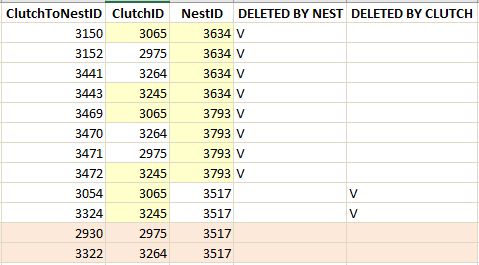

meaning that for this nest - two clutches still lead to it

In [36]:
df_ClutchToNest.loc[df_ClutchToNest.NestID==3517]

,ClutchToNestID,ClutchID,NestID,EggsRelocated
1731,2930,2975,3517,82.0
1978,3322,3264,3517,82.0


### next - I'll check these crawls that lead to the same nest- are they duplicated as well?

In [37]:
### inspect Clutch-to-Nests df. are there clutches that point to the same nest? 
print(df_ClutchToNest.NestID.nunique(), df_ClutchToNest.shape)


1953 (1979, 4)


In [38]:
df_ClutchToNest.NestID.duplicated().sum()


26

In [39]:
df_ClutchToNest[df_ClutchToNest.NestID.duplicated(keep=False)].sort_values('NestID')

,ClutchToNestID,ClutchID,NestID,EggsRelocated
1139,1287,1526,2379,48.0
1140,1288,1529,2379,27.0
1200,1348,1534,2440,69.0
1251,1404,1535,2440,34.0
1208,1357,1565,2449,69.0
1253,1407,1563,2449,9.0
1071,1215,1619,2498,61.0
1072,1216,1618,2498,8.0
1366,1544,1859,2659,89.0
1367,1545,1860,2659,1.0


in some cases the number of eggs relocated is identical (suspect to be duplicated), but in some it's different - which can happen in reality - when two clutches are being put inside the same nest.

In [40]:
colnames = ['EggsNo', 'DeptTopEgg', 'DepthBottomEgg',
       'NestDiameter', 'NestDistance', 'BrokenOnRelocation', 'Predation',
       'PreyedEggs', 'CollectingDate', 'CollectionHour', 'CollectorID',
       'RelocationDate', 'RelocationHour', 'RelocatorID', 'WasRelocated']


crawl_colnames= ['Nest', 'ListingDate', 'CrawlDate', 'OnlyYear',
       'Location', 'North', 'East', 'DescriptionOfCrawl', 'SpecieID',
       'NumOfDigs', 'TrackMin', 'TrackMax', 'MaxDistanceFromWater', 'Notes',
       'Locked', 'TurtleNickName', 'TurtleID', 'CrawlOwner', 'CrawlOwnerCode',
       'CrawlAddingDate', 'SpecieId', 'SpecieNameEng', 'SpecieNameLatin',
       'LocationID', 'LocationName', 'MiktaID', 'Xmax', 'Ymax', 'Xmin', 'Ymin',
       'Region', 'RegionId', 'RegionName', 'other_observers_names',
       'main_observer_name', 'contacts_ids', 'predation', 'Fox', 'Dog', 'Man',
       'unknown', 'crab', 'Crow', 'Cat', 'Crab']

nestids= set(df_ClutchToNest[df_ClutchToNest.NestID.duplicated(keep=False)]['NestID'])

duplicated_clutches_ids = []
duplicated_crawls_ids = []

crawlsids_to_excel=[]
not_duplicated_crawlids=dict()
n=0

for nestid in nestids:
    nest= df_Nest.loc[df_Nest.NestID==nestid]
    print('nestid: ',nestid)
    clutchtonests = df_ClutchToNest.loc[df_ClutchToNest.NestID==nestid]
#     print(clutchtonests)
    clutchids = list(df_ClutchToNest[df_ClutchToNest.NestID==nestid]['ClutchID'].values)
#     print(clutchids)
    clutches = df_Clutches[df_Clutches.ClutchID.isin(clutchids)]
    print(clutches['ClutchID'])
    
    duplicated_c=clutches.duplicated(subset=colnames,keep='first') 
#     print(duplicated_c)
    is_duplicated= duplicated_c.any()
    print('is_clutch_duplicated: ',is_duplicated)
    
    if is_duplicated:
        crawlids =list(clutches.CrawlID.values)
        crawls = df_Crawl.loc[df_Crawl.CrawlID.isin(crawlids)]
        print(crawlids)
        
        duplicated_c_crawls=crawls.duplicated(subset=crawl_colnames,keep='first') 
        is_duplicated_crawls= duplicated_c_crawls.any()
        print('is_duplicated_crawls? ',is_duplicated_crawls)
        
        if is_duplicated_crawls:
            duplicated_clutches_ids = duplicated_clutches_ids+list(clutches[duplicated_c]['ClutchID'].values)
            duplicated_crawls_ids = duplicated_crawls_ids+list(crawls[duplicated_c_crawls]['CrawlID'].values)
            print('duplicated_clutches_ids ',duplicated_clutches_ids)
            print('duplicated_crawls_ids: ',duplicated_crawls_ids)
        else:
            print('is_duplicated_crawls: ', is_duplicated_crawls)
            print('crawl_ids: ',crawls['CrawlID'])
            crawlsids_to_excel = crawlsids_to_excel+list(crawls['CrawlID'].values)
            not_duplicated_crawlids[n]=list(crawls['CrawlID'].values)
            n+=1

            
duplicated_clutches_ids=set(duplicated_clutches_ids)
duplicated_crawls_ids=set(duplicated_crawls_ids)

print(duplicated_clutches_ids)
print(duplicated_crawls_ids)

nestid:  3845
1962    3195
2026    3294
Name: ClutchID, dtype: int64
is_clutch_duplicated:  True
[162103, 162235]
is_duplicated_crawls?  True
duplicated_clutches_ids  [3294]
duplicated_crawls_ids:  [162235]
nestid:  2440
1111    1534
1112    1535
Name: ClutchID, dtype: int64
is_clutch_duplicated:  False
nestid:  2960
1490    2178
1491    2179
Name: ClutchID, dtype: int64
is_clutch_duplicated:  False
nestid:  2449
1140    1563
1142    1565
Name: ClutchID, dtype: int64
is_clutch_duplicated:  False
nestid:  3498
1791    2961
1982    3250
Name: ClutchID, dtype: int64
is_clutch_duplicated:  True
[161696, 162168]
is_duplicated_crawls?  True
duplicated_clutches_ids  [3294, 3250]
duplicated_crawls_ids:  [162235, 162168]
nestid:  2988
1519    2207
1541    2229
Name: ClutchID, dtype: int64
is_clutch_duplicated:  False
nestid:  3500
1792    2962
1983    3251
Name: ClutchID, dtype: int64
is_clutch_duplicated:  True
[161698, 162170]
is_duplicated_crawls?  True
duplicated_clutches_ids  [3294, 3250, 

In [41]:
print(duplicated_clutches_ids)
print(duplicated_crawls_ids)

{3264, 3258, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3290, 3291, 3262, 3261, 3294, 3263}
{162176, 162178, 162179, 162232, 162186, 162187, 162188, 162189, 162168, 162233, 162170, 162235, 162172, 162173, 162174, 162175}


In [42]:
## ill inspect these not duplicated entities in excel
crawls_to_excel = df_Crawl.loc[df_Crawl.CrawlID.isin(crawlsids_to_excel)]
# crawls_to_excel.to_excel('crawls_to_excel.xlsx')

Inspecting it in excel :

The only difference is in contact names and ids.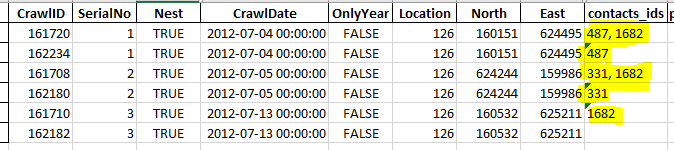

crawlids = 161720, 162234, 161708, 162180, 161710, 162182

So I'll keep the ones where there are more contacts.

In [43]:
for id in not_duplicated_crawlids:
    crawlids= not_duplicated_crawlids[id]
    crawlids=crawlids.copy()
    
    crawls = df_Crawl.loc[df_Crawl.CrawlID.isin(crawlids)]
#     print(crawls)
#     print(crawls['contacts_ids'])
    
    lengths = crawls["contacts_ids"].str.len()
    argmin = np.where(lengths == lengths.min())[0]
#     argmax = np.where(lengths == lengths.max())[0]
    crawlid_to_keep = crawls.iloc[argmin].CrawlID.values[0]
# #     print(crawlid_to_keep)
    
    crawlids.remove(crawlid_to_keep)
#     print(crawlids)
    duplicated_crawls_ids.add(crawlids[0])

In [44]:
### delete these clutches from clutches df, clutch to nest df, and from crawls!

df_Crawl_clean = df_Crawl.loc[~df_Crawl.CrawlID.isin(duplicated_crawls_ids)]
df_Clutches_clean = df_Clutches.loc[~df_Clutches.ClutchID.isin(duplicated_clutches_ids)]
df_ClutchToNest_clean = df_ClutchToNest.loc[~df_ClutchToNest.ClutchID.isin(duplicated_clutches_ids)]


In [45]:
len(df_Crawl) == len(df_Crawl_clean)+len(duplicated_crawls_ids)

True

In [46]:
len(df_Clutches) == len(df_Clutches_clean)+len(duplicated_clutches_ids)

True

In [47]:
len(df_ClutchToNest) == len(df_ClutchToNest_clean)+len(duplicated_clutches_ids)

True

In [48]:
###  saving cleaned tables in the main table name
df_Crawl = df_Crawl_clean
df_Clutches = df_Clutches_clean
df_ClutchToNest = df_ClutchToNest_clean


In [49]:

## are there still duplications in crawls?

df_Crawl.duplicated(subset=crawl_colnames,keep='first').sum()

43

In [67]:
duplicated_crawls = df_Crawl.loc[df_Crawl.duplicated(subset=crawl_colnames,keep='first')]
pd.set_option('display.max_rows', None)
duplicated_crawls



,CrawlID,SerialNo,Nest,ListingDate,CrawlDate,OnlyYear,Location,North,East,DescriptionOfCrawl,...,contacts_ids,predation,Fox,Dog,Man,unknown,crab,Crow,Cat,Crab
225,238,NaN,False,NaT,1988-07-02,False,131.0,617700.0,155800.0,None,...,541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,290,NaN,False,NaT,1987-07-16,False,4.0,775500.0,210300.0,None,...,460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,374,9.0,False,NaT,1985-06-24,False,68.0,NaN,NaN,חוף הבונים,...,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,375,8.0,False,NaT,1985-06-24,False,68.0,NaN,NaN,חוף הבונים,...,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,378,NaN,False,NaT,1985-07-06,False,61.0,NaN,NaN,ג'סר א-זרקא,...,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321,379,NaN,False,NaT,1985-07-05,False,61.0,NaN,NaN,ג'סר א-זרקא,...,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,1503,17.0,False,NaT,1999-06-06,False,51.0,728700.0,193400.0,כ-600 מ' מצפון לשמורת הבונים,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,1744,17.0,False,NaT,2000-06-21,False,127.0,623000.0,159300.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,1995,41.0,False,NaT,2000-07-01,False,84.0,683800.0,183800.0,פולג. מדרום ל-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,1997,43.0,False,NaT,2000-07-01,False,83.0,685800.0,184300.0,מצפון לחסימה דרומית,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
## it might be ok. let's check to which clutches and nests they lead 

In [52]:
crawlids= df_Crawl.loc[df_Crawl.duplicated(subset=crawl_colnames,keep='first')].CrawlID.values
df_Clutches.loc[df_Clutches.CrawlID.isin(crawlids)]

,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,RelocationDate,RelocationHour,RelocatorID,WasRelocated,CollectorContact,RelocatorContact
539,545,2703,95.0,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN


In [53]:
crawlids

array([   238,    290,    374,    375,    378,    379,   1503,   1744,
         1995,   1997,   2007,   2008,   2009,   2010,   2011,   2012,
         2013,   2365,   2366,   2703,   2747,   2771,   2778,   2779,
         2803,   2812,   3044,   3064,   3065,   5283,   5284,   5285,
         5286,   5287, 162165, 162166, 162167, 162169, 162171, 162177,
       162181, 162184, 162185], dtype=int64)

Except one of them -  they don't lead to clutches. so if they are duplicated- it's ok to remove them
* excpet of cralid=2703

In [54]:
# ### DUPLICATED CHECK:
# ### after running the script I realised that there are two crawl rows that were removed because they are duplicated, but they are connected to nests. So I'll merge them back to get them in the final table.
# print(len(df_Crawl))
# # print(len(duplicated_rows_to_add))

# duplicated_rows_to_add = df_Crawl_oiginal.loc[df_Crawl_oiginal.CrawlID.isin([162180,2703])]

# df_Crawl_with_2_duplicated_rows_back = pd.concat([df_Crawl,duplicated_rows_to_add], ignore_index=True)
# print(len(df_Crawl_with_2_duplicated_rows_back))


# df_Crawl = df_Crawl_with_2_duplicated_rows_back
# print(len(df_Crawl))

# df_Crawl.loc[df_Crawl.CrawlID.isin([162180,2703])]


In [525]:
df_Crawl=df_Crawl.drop_duplicates(subset=crawl_colnames,keep='first')

In [528]:
def get_clutchtonests_from_nestid(nestid):
    clutchtonest =  df_ClutchToNest.loc[df_ClutchToNest.NestID==nestid]
    return clutchtonests

def get_clutches_from_nestid(nestid):
    clutchtonest =  df_ClutchToNest.loc[df_ClutchToNest.NestID==nestid]
#         clutchtonest =  get_clutchtonests_from_nestid(nestid)
    clutchid_from_nest =clutchtonest.ClutchID.values
    clutch = df_Clutches.loc[df_Clutches.ClutchID.isin(clutchid_from_nest)]
    return(clutch)

def get_crawls_from_clutchids(clutchids):
    crawlids = df_Clutches.loc[df_Clutches.ClutchID.isin(clutchids)]['CrawlID']
    crawls= df_Crawl.loc[df_Crawl.CrawlID.isin(crawlids)]
    return crawls

def get_clutchtonests_from_clutchids(clutchids):
    clutchtonests = df_ClutchToNest.loc[df_ClutchToNest.ClutchID.isin(clutchids)]
    return clutchtonests


def get_nests_from_clutchids(clutchids):
    clutchtonests = get_clutchtonests_from_clutchids(clutchids)
    nests_ids = clutchtonests.NestID.values
    nests = df_Nest.loc[df_Nest.NestID.isin(nests_ids)]
    return nests


In [529]:
# nestid = 4088
# clutchid_from_nest = df_ClutchToNest.loc[df_ClutchToNest.NestID==nestid]
# clutch = df_Clutches.loc[df_Clutches.ClutchID==clutchid_from_nest]

In [530]:
for nestid in df_Nest['NestID'].values:
    clutches = get_clutches_from_nestid(nestid = nestid)
    if len(clutches)>1:
#         print(clutches)
        a= clutches.duplicated(subset = ['EggsNo', 'DeptTopEgg', 'DepthBottomEgg',
       'NestDiameter', 'NestDistance', 'BrokenOnRelocation', 'Predation',
       'PreyedEggs', 'CollectingDate', 'CollectionHour',
       'RelocationDate', 'RelocationHour', 'WasRelocated'])
        if a.any():
            clutches_ids = clutches['ClutchID'].values
#             print(clutches_ids)
            crawls = get_crawls_from_clutchids(clutchids=clutches_ids)
            print(clutches)
            print(crawls)
            


      ClutchID  CrawlID  EggsNo  DeptTopEgg  DepthBottomEgg  NestDiameter   
1808      2978   161720    84.0        36.0            53.0          22.0  \
2024      3292   162234    84.0        36.0            53.0          22.0   

      NestDistance  BrokenOnRelocation   Predation  PreyedEggs CollectingDate   
1808          33.0                 0.0  Not prayed         0.0     2012-07-04  \
2024          33.0                 0.0  Not prayed         0.0     2012-07-04   

          CollectionHour  CollectorID RelocationDate      RelocationHour   
1808 1899-12-30 07:40:00        487.0     2012-07-04 1899-12-30 08:30:00  \
2024 1899-12-30 07:40:00        487.0     2012-07-04 1899-12-30 08:30:00   

      RelocatorID  WasRelocated CollectorContact RelocatorContact  
1808          NaN          True     Yatir Shamir              NaN  
2024          NaN          True     Yatir Shamir              NaN  
      CrawlID  SerialNo  Nest ListingDate  CrawlDate  OnlyYear  Location   
3883   162234  

In [531]:
### these crawls are not exising anymore. I'll remove the clutches that still lead to them:
clutchids_to_remove = [2978,3259, 3260]

## making sure there's only one clutchtonest entity:
clutchtonest =get_clutchtonests_from_clutchids(clutchids=clutchids_to_remove)


In [532]:
df_Clutches = df_Clutches.loc[~df_Clutches.ClutchID.isin(clutchids_to_remove)]

In df_Crawls - it's noted if there's a nest or not in column 'Nest'


In [533]:
df_Crawl.loc[df_Crawl.Nest==False].drop(['CrawlDate','North','East','Location'],axis=1)  ##dropping sensitive data


,CrawlID,SerialNo,Nest,ListingDate,OnlyYear,DescriptionOfCrawl,SpecieID,NumOfDigs,TrackMin,TrackMax,...,predation,Fox,Dog,Man,unknown,crab,Crow,Cat,Crab,RegionalCrawlID
31,33,7.0,False,NaT,False,None,2.0,4.0,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,34,8.0,False,NaT,False,None,2.0,5.0,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,36,12.0,False,NaT,False,None,2.0,1.0,NaN,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,37,14.0,False,NaT,False,כפר גלים,2.0,0.0,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,38,18.0,False,NaT,False,None,2.0,1.0,NaN,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,162427,NaN,False,NaT,False,None,2.0,NaN,70.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4076,162428,NaN,False,NaT,False,None,2.0,NaN,70.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4077,162429,NaN,False,NaT,False,None,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4078,162430,NaN,False,NaT,False,None,8.0,1.0,80.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


are all these crawls indeed lead to no clutch?

In df_Clutches:
If there's a nest - it is noted if the nest was relocated or not in column 'WasRelocated'.

Are there crawls without nest that was found in the clutches tabke and also noted as relocated?

In [534]:
crawls_without_nest=df_Crawl.loc[df_Crawl.Nest==False]['CrawlID'].values

crawls_without_nests_and_relocated = df_Clutches[df_Clutches.CrawlID.isin(crawls_without_nest)& df_Clutches.WasRelocated==True]
crawls_without_nests_and_relocated

,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,RelocationDate,RelocationHour,RelocatorID,WasRelocated,CollectorContact,RelocatorContact
977,989,4060,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,2007-06-24,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1455,2143,5607,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1457,2145,5609,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1462,2150,5614,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1463,2151,5615,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1464,2152,5616,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1465,2153,5617,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1467,2155,5619,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1471,2159,5623,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN
1515,2203,5674,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True,NaN,NaN


It seems that there are clutches that were relocated!
To make sure - I'll check if they are really appearing in the clutchtonest table

In [535]:
clutchids= crawls_without_nests_and_relocated['ClutchID'].values

df_ClutchToNest.loc[df_ClutchToNest.ClutchID.isin(clutchids)].shape

(0, 4)

They don't lead to a nest - meaning that there is no nest even if we fount them in the clutches table. 

In [536]:
clutchtonest_lengths=[]
for clutchid in df_Clutches.ClutchID.values:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]
    if len(clutchtonest)>1:
        clutchtonest_lengths.append(len(clutchtonest))
print(len(clutchtonest_lengths))

### meaning that one clutch leads to few nests. lets check it


42


meaning that in 42 cases- one clutch leads to few nests. lets check it


when we inspect turtles data - we check wether the number of eggs that was relocaated - is the number of newborns (not very accurate) or of the shells (more accurate). let's inspect that:


In [537]:
for clutchid in df_Clutches.ClutchID.values:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]
    if len(clutchtonest)>1:
        clutch = df_Clutches.loc[df_Clutches.ClutchID==clutchid]
        nestids = clutchtonest.NestID.values
        nests = df_Nest.loc[df_Nest.NestID.isin(nestids)]

        total_eggs = nests['EmptyShells'].sum() + nests['UndevelopedEggs'].sum() + nests['DeadInEggs'].sum()
        col_list = ['LiveInNest', 'DeadInNest', 'DeadInEggs', 'UndevelopedEggs']
        indication_for_n_turtles = nests[col_list].sum(axis=1)

        eggs_n = clutch['EggsNo'].values[0]
        clutchtonest_eggs_n = clutchtonest.EggsRelocated.sum()
        
        print('clutch - eggs number: ',eggs_n)
        print('clutchtonest - eggs number: ', clutchtonest_eggs_n)

        print('nests - total_eggs: ', total_eggs)
#         print('indication_for_n_turtles: ',indication_for_n_turtles.values)



clutch - eggs number:  120.0
clutchtonest - eggs number:  120.0
nests - total_eggs:  51.0
clutch - eggs number:  127.0
clutchtonest - eggs number:  127.0
nests - total_eggs:  15.0
clutch - eggs number:  127.0
clutchtonest - eggs number:  125.0
nests - total_eggs:  21.0
clutch - eggs number:  115.0
clutchtonest - eggs number:  115.0
nests - total_eggs:  11.0
clutch - eggs number:  57.0
clutchtonest - eggs number:  110.0
nests - total_eggs:  2.0
clutch - eggs number:  103.0
clutchtonest - eggs number:  103.0
nests - total_eggs:  12.0
clutch - eggs number:  118.0
clutchtonest - eggs number:  118.0
nests - total_eggs:  3.0
clutch - eggs number:  77.0
clutchtonest - eggs number:  67.0
nests - total_eggs:  0.0
clutch - eggs number:  105.0
clutchtonest - eggs number:  103.0
nests - total_eggs:  1.0
clutch - eggs number:  123.0
clutchtonest - eggs number:  123.0
nests - total_eggs:  5.0
clutch - eggs number:  110.0
clutchtonest - eggs number:  110.0
nests - total_eggs:  4.0
clutch - eggs numbe

if the number of shells is 0 - it make sense- nobody checked it (mainly in older data)
and if the numbers are close to each other- it makes sense - small mistackes in counting.

what doesn't make sense - if number of eggs relocated is different then original number of eggs.
so I'll inspect that:


In [538]:
for clutchid in df_Clutches.ClutchID.values:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]
    if len(clutchtonest)>1:
        clutch = df_Clutches.loc[df_Clutches.ClutchID==clutchid]
        nestids = clutchtonest.NestID.values
        nests = df_Nest.loc[df_Nest.NestID.isin(nestids)]

        total_eggs = nests['EmptyShells'].sum() + nests['UndevelopedEggs'].sum() + nests['DeadInEggs'].sum()
        col_list = ['LiveInNest', 'DeadInNest', 'DeadInEggs', 'UndevelopedEggs']
        indication_for_n_turtles = nests[col_list].sum(axis=1)

        eggs_n = clutch['EggsNo'].values[0]
        clutchtonest_eggs_n = clutchtonest.EggsRelocated.sum()
        
        if clutchtonest_eggs_n != eggs_n:
            print('clutch id:', clutchid)
            print('clutch - eggs number: ',eggs_n)
            print('clutchtonest - eggs number: ', clutchtonest_eggs_n)
            print('nests- opening - total_eggs: ', total_eggs)

            print(clutch)
            print(clutchtonest)
            print(nests)
            print('------------------')

            

clutch id: 196
clutch - eggs number:  127.0
clutchtonest - eggs number:  125.0
nests- opening - total_eggs:  21.0
     ClutchID  CrawlID  EggsNo  DeptTopEgg  DepthBottomEgg  NestDiameter   
194       196      978   127.0         NaN             NaN           NaN  \

     NestDistance  BrokenOnRelocation         Predation  PreyedEggs   
194           NaN                 NaN  Partially preyed         2.0  \

    CollectingDate CollectionHour  CollectorID RelocationDate RelocationHour   
194            NaT            NaT          NaN            NaT            NaT  \

     RelocatorID  WasRelocated CollectorContact RelocatorContact  
194          NaN          True              NaN              NaN  
      ClutchToNestID  ClutchID  NestID  EggsRelocated
191              195       196     207           63.0
1274            1444       196    2555           62.0
      NestID HatcheryNestNo  HatcheryID HatchingDate OpeningDate OpeningHour   
191      207              1         1.0   1997-07-30 

in some of the cases there is a mistake - for example- a total of 125 (63+62), when the original egss number is 127.
* take into consideration that the number of eggs from the nests table is the least accurate because sometimes the opener didn't calculate it thoroughly.

I went throgh these results and created a list with the only two that needs further inspection:

In [539]:
clutchids_for_inspection = [451, 751 ]
for clutchid in clutchids_for_inspection:
    clutchtonest = df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]
    clutch = df_Clutches.loc[df_Clutches.ClutchID==clutchid]
    crawlid = df_Clutches.loc[df_Clutches.ClutchID==clutchid].CrawlID.values[0]
    print(crawlid)
    crawl = df_Crawl.loc[df_Crawl.CrawlID==crawlid]
    nestids = clutchtonest.NestID.values
    nests = df_Nest.loc[df_Nest.NestID.isin(nestids)]

    total_eggs = nests['EmptyShells'].sum() + nests['UndevelopedEggs'].sum() + nests['DeadInEggs'].sum()
    col_list = ['LiveInNest', 'DeadInNest', 'DeadInEggs', 'UndevelopedEggs']
    indication_for_n_turtles = nests[col_list].sum(axis=1)

    eggs_n = clutch['EggsNo'].values[0]
    clutchtonest_eggs_n = clutchtonest.EggsRelocated.sum()

    print('clutch id:', clutchid)
    print('clutch - eggs number: ',eggs_n)
    print('clutchtonest - eggs number: ', clutchtonest_eggs_n)
    print('nests- opening - total_eggs: ', total_eggs)
    print('--------')
    print(crawl)
    print(clutch)
    print(clutchtonest)
    print(nests)
    print('------------------')

            

2219
clutch id: 451
clutch - eggs number:  57.0
clutchtonest - eggs number:  110.0
nests- opening - total_eggs:  2.0
--------
     CrawlID  SerialNo  Nest ListingDate  CrawlDate  OnlyYear  Location   
925     2219       5.0  True         NaT 2001-06-12     False      12.0  \

        North      East        DescriptionOfCrawl  ...  predation  Fox  Dog   
925  769300.0  208900.0  כ400 מ' מצפון לבטוניאדות  ...        NaN  NaN  NaN  \

     Man  unknown crab  Crow Cat  Crab  RegionalCrawlID  
925  NaN      NaN  NaN   NaN NaN   NaN              NaN  

[1 rows x 48 columns]
     ClutchID  CrawlID  EggsNo  DeptTopEgg  DepthBottomEgg  NestDiameter   
447       451     2219    57.0         NaN             NaN           NaN  \

     NestDistance  BrokenOnRelocation   Predation  PreyedEggs CollectingDate   
447           NaN                 NaN  Not preyed         0.0            NaT  \

    CollectionHour  CollectorID RelocationDate RelocationHour  RelocatorID   
447            NaT          NaN  

I'll keep them. they'll need to be inspected by the biologist

### exporting data


In [540]:
## first- creating 4 tables exactly as they will be imported to TIMI

In [541]:
### making sure again that every crawl leads to only one clutch  
print(df_Clutches.CrawlID.nunique())
print(df_Clutches.ClutchID.nunique())

2117
2117


In [542]:
### adding hatchery name:
# HatcheryID

df_clutches_relevant = df_Clutches[['ClutchID','CrawlID','Predation', 'WasRelocated', 'DeptTopEgg',
                                    'DepthBottomEgg', 'NestDiameter', 'EggsNo',
                                    'BrokenOnRelocation', 'PreyedEggs', 'CollectingDate', 
                                    'CollectionHour', 'CollectorID', 'CollectorContact', 
                                   ]]

df_Crawl_for_export = pd.merge(df_Crawl, df_clutches_relevant, left_on='CrawlID', right_on='CrawlID', how='left')
df_Crawl_for_export
# df_Crawl_for_export.columns

,CrawlID,SerialNo,Nest,ListingDate,CrawlDate,OnlyYear,Location,North,East,DescriptionOfCrawl,...,DeptTopEgg,DepthBottomEgg,NestDiameter,EggsNo,BrokenOnRelocation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,CollectorContact
0,2,NaN,True,NaT,1994-06-13,False,51.0,728400.0,193400.0,None,...,50.0,77.0,37.0,116.0,NaN,0.0,NaT,NaT,NaN,NaN
1,3,2.0,True,NaT,1994-06-02,False,42.0,742700.0,196000.0,טירת כרמל,...,32.0,45.0,28.0,91.0,NaN,0.0,NaT,NaT,NaN,NaN
2,4,3.0,True,NaT,1994-06-02,False,49.0,731000.0,193600.0,None,...,29.0,44.0,22.0,73.0,NaN,0.0,NaT,NaT,NaN,NaN
3,5,6.0,True,NaT,1994-06-10,False,56.0,723700.0,192300.0,None,...,28.0,50.0,NaN,114.0,NaN,0.0,NaT,NaT,NaN,NaN
4,6,11.0,True,NaT,1994-06-14,False,44.0,737200.0,195400.0,None,...,27.0,43.0,29.0,87.0,NaN,0.0,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134,162487,NaN,True,2016-05-15,2015-07-04,False,81.0,NaN,NaN,None,...,30.0,49.0,14.0,72.0,1.0,0.0,2015-07-04,1899-12-30 07:50:00,1024.0,Asaf Kaplan
4135,162488,NaN,True,2016-05-15,2015-07-13,False,82.0,689422.0,185128.0,None,...,35.0,52.0,22.0,65.0,0.0,0.0,2015-07-13,1899-12-30 07:00:00,397.0,Yariv Malichi
4136,162489,NaN,True,2016-05-15,2015-07-13,False,83.0,686448.0,184399.0,None,...,22.0,45.0,15.0,52.0,0.0,0.0,2015-07-13,1899-12-30 06:00:00,397.0,Yariv Malichi
4137,2703,6.0,True,NaT,2002-06-17,False,126.0,626000.0,161000.0,None,...,NaN,NaN,NaN,95.0,NaN,0.0,NaT,NaT,NaN,NaN


In [543]:
## there are more nestids then clutchids - one clutch leads to few nests.
print(df_ClutchToNest.ClutchID.nunique())
print(df_ClutchToNest.NestID.nunique())

## So I want to keep all nests and attach to it the relevant data from the clutches.

1921
1953


In [544]:
### adding specie information to clutch
df_Clutch_sp = pd.merge(df_Clutches, df_Crawl_for_export[['CrawlID','SpecieID','SpecieNameEng','SpecieNameLatin']],
                        left_on='CrawlID', right_on='CrawlID', how='left')
# df_Clutch_sp
df_Nest_relevant = df_Nest[['NestID','HatcheryNorth', 'HatcherySouth', 'HatcheryName', 'HatcheryID', 'HatcheryNestNo']]
df_Clutches_relevant = df_Clutch_sp[['ClutchID',
                                     'CrawlID','SpecieID','SpecieNameEng','SpecieNameLatin',
                                     'RelocationDate', 'RelocationHour', 'RelocatorContact',
                                    'RelocatorID', 'BrokenOnRelocation']]
# df_ClutchToNest_clutchid = df_ClutchToNest[]


df_Nest_ClutchToNest = pd.merge(df_Nest_relevant, df_ClutchToNest,
                                        left_on='NestID', right_on='NestID', how='left')



# ### there are nests without clutches. these- I'll export seperately and check with the Biologisy
# df_Nest_ClutchToNest_NA_to_export = df_Nest_ClutchToNest[df_Nest_ClutchToNest.ClutchID.isna()]

# df_Nest_ClutchToNest = df_Nest_ClutchToNest.dropna()

# df_Nest_ClutchToNest


In [545]:
df_Nest_Relocated_for_export = pd.merge(df_Nest_ClutchToNest, df_Clutches_relevant,
                                        left_on='ClutchID', right_on='ClutchID', how='left')

df_Nest_Relocated_for_export

,NestID,HatcheryNorth,HatcherySouth,HatcheryName,HatcheryID,HatcheryNestNo,ClutchToNestID,ClutchID,EggsRelocated,CrawlID,SpecieID,SpecieNameEng,SpecieNameLatin,RelocationDate,RelocationHour,RelocatorContact,RelocatorID,BrokenOnRelocation
0,1,NaN,NaN,-InSitu-,10.0,None,1.0,1.0,NaN,195.0,2.0,Loggerhead,Caretta caretta,NaT,NaT,NaN,NaN,NaN
1,2,NaN,NaN,-InSitu-,10.0,None,2.0,2.0,NaN,196.0,2.0,Loggerhead,Caretta caretta,NaT,NaT,NaN,NaN,NaN
2,3,NaN,NaN,-InSitu-,10.0,None,3.0,3.0,NaN,197.0,2.0,Loggerhead,Caretta caretta,NaT,NaT,NaN,NaN,NaN
3,10,NaN,NaN,-InSitu-,10.0,None,10.0,10.0,100.0,232.0,2.0,Loggerhead,Caretta caretta,NaT,NaT,NaN,NaN,NaN
4,13,NaN,NaN,-InSitu-,10.0,None,13.0,13.0,NaN,270.0,2.0,Loggerhead,Caretta caretta,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,4081,708300.0,668000.0,Gdor,4.0,18,3699.0,3439.0,65.0,162484.0,2.0,Loggerhead,Caretta caretta,2015-07-02,1899-12-30 08:30:00,Ori Shapira,1099.0,0.0
2070,4082,708300.0,668000.0,Gdor,4.0,19,3701.0,3440.0,77.0,162485.0,2.0,Loggerhead,Caretta caretta,2015-07-04,1899-12-30 12:15:00,Asaf Kaplan,1024.0,NaN
2071,4087,708300.0,668000.0,Gdor,4.0,20,3707.0,3442.0,71.0,162487.0,2.0,Loggerhead,Caretta caretta,2015-07-04,1899-12-30 13:00:00,Asaf Kaplan,1024.0,1.0
2072,4088,708300.0,668000.0,Gdor,4.0,23,3708.0,3443.0,65.0,162488.0,2.0,Loggerhead,Caretta caretta,2015-07-13,1899-12-30 09:00:00,Yariv Malichi,397.0,0.0


In [546]:
df_Immerging_for_export = df_Immerging[['ImmergeID', 'NestID','ImmergeDay', 'ImmergeTimeS', 'ImmergeTimeE',
                                        'HatcherySouth', 'HatcheryNorth', 'HatcheryName',
                                        'HatcheryID', 'NoOfTurtles', 'ImmregeRemarks']]
df_Immerging_for_export

,ImmergeID,NestID,ImmergeDay,ImmergeTimeS,ImmergeTimeE,HatcherySouth,HatcheryNorth,HatcheryName,HatcheryID,NoOfTurtles,ImmregeRemarks
0,632,2009,2007-08-30,1899-12-30 00:00:00,NaT,668000.0,708300.0,Gdor,4.0,14.0,0.0
1,633,2009,2007-08-30,1899-12-30 03:00:00,NaT,668000.0,708300.0,Gdor,4.0,2.0,0.0
2,634,2009,2007-08-30,1899-12-30 04:30:00,NaT,668000.0,708300.0,Gdor,4.0,2.0,0.0
3,635,2009,2007-08-29,1899-12-30 23:30:00,NaT,668000.0,708300.0,Gdor,4.0,1.0,0.0
4,636,2009,2007-08-29,1899-12-30 02:20:00,NaT,668000.0,708300.0,Gdor,4.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4833,6391,4004,2014-08-28,NaT,1899-12-30 08:30:00,NaN,NaN,Difle,11.0,1.0,0.0
4834,6392,4005,2014-08-23,NaT,1899-12-30 21:50:00,NaN,NaN,Difle,11.0,4.0,0.0
4835,6393,4007,2014-07-30,NaT,1899-12-30 04:00:00,749000.0,778000.0,Betzet,1.0,50.0,0.0
4836,6394,4007,2014-07-30,NaT,1899-12-30 14:00:00,749000.0,778000.0,Betzet,1.0,1.0,0.0


In [547]:
df_Nest_Opening_for_export = df_Nest[["NestID", "OpeningDate", "OpeningHour",
                                      "NestOpenerName", "OpenerID",'NestOwner', "NestOwnerName",
                                      "HatcherySouth", "HatcheryNorth", "HatcheryName",
                                      "HatcheryID", "HatcheryNestNo", "EmptyShells", "DeadInEggs",
                                      "LiveInNest", "UndevelopedEggs", "DeadInNest", "OpeningNotes", 
]]

In [551]:
### export to excel

# df_Crawl_for_export.to_excel('df_Crawl_for_export.xlsx')
### df_Crawl_for_export.to_excel('df_Crawl_with_2_duplicated_for_export.xlsx')

# df_Nest_Relocated_for_export.to_excel('df_Nest_Relocated_for_export.xlsx')
# df_Immerging_for_export.to_excel('df_Immerging_for_export.xlsx')
# df_Nest_Opening_for_export.to_excel('df_Nest_Opening_for_export.xlsx')
